ViT Model trained on FER2013 from https://huggingface.co/trpakov/vit-face-expression

In [1]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

/Users/kai/miniconda3/envs/car/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kai/miniconda3/envs/car/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <253997FD-685F-34A9-B3D7-4AF6DAE96CDF> /Users/kai/miniconda3/envs/car/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/kai/miniconda3/envs/car/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/kai/miniconda3/envs/car/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/kai/miniconda3/envs/car/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/kai/miniconda3/envs/car/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

In [12]:
import numpy as np
import pandas as pd

In [3]:
processor.do_convert_rgb = True
processor.do_rgb_to_grayscale = True

In [4]:
processor

ViTImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "do_rgb_to_grayscale": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Download dataset from https://figshare.com/articles/figure/DVM-CAR_Dataset/19586296/1?file=34792480
Place under `data/images`

In [5]:
TEST_IMAGE_PATH = "data/images/confirmed_fronts/Lexus/2017/Lexus$$RX 450h$$2017$$Red$$48_24$$468$$image_1.jpg"
CLASS_INDEX = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

In [6]:
from PIL import Image

def predict_expression(image_path):
    # Open the image
    # image = Image.open(image_path)
    gray_image = Image.open(image_path).convert('L')
    image = gray_image.convert('RGB')

    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt")
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    predicted_class_idx = outputs.logits.argmax(-1).item()
    predicted_prob = outputs.logits[0].softmax(-1).tolist()
    
    # Get the human-readable label
    label = CLASS_INDEX[predicted_class_idx]
    
    return image, label, predicted_prob

In [7]:
import matplotlib.pyplot as plt

def visualize_images(image_paths):
    num_images = len(image_paths)
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for idx, image_path in enumerate(image_paths):
        # Predict expression
        image, label, _ = predict_expression(image_path)
        
        # If there's only one image, `axes` is not a list.
        ax = axes if num_images == 1 else axes[idx]
        
        # Display the image
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

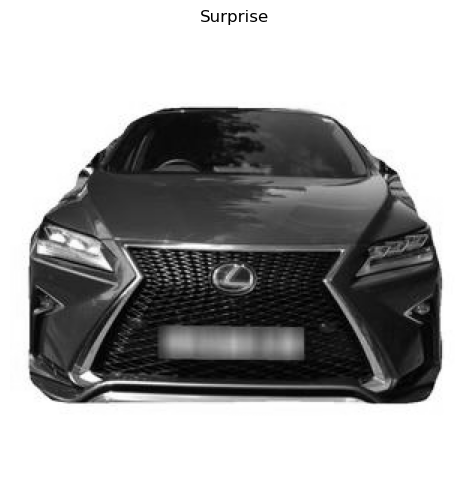

In [8]:
visualize_images([TEST_IMAGE_PATH,])

In [9]:
image_paths = [
    "data/images/confirmed_fronts/Lexus/2017/Lexus$$RX 450h$$2017$$Red$$48_24$$468$$image_1.jpg",
    "data/images/confirmed_fronts/Audi/2017/Audi$$Q5$$2017$$Black$$7_20$$1219$$image_5.jpg",
    "data/images/confirmed_fronts/Tesla/2017/Tesla$$Model X$$2017$$White$$90_2$$8$$image_0.jpg",
    "data/images/confirmed_fronts/Toyota/2017/Toyota$$RAV4$$2017$$Silver$$92_34$$164$$image_0.jpg",
    "data/images/confirmed_fronts/Subaru/2017/Subaru$$Outback$$2017$$Black$$86_7$$89$$image_4.jpg",
    "data/images/confirmed_fronts/Bentley/2017/Bentley$$Continental$$2017$$Grey$$10_5$$700$$image_5.jpg"
]

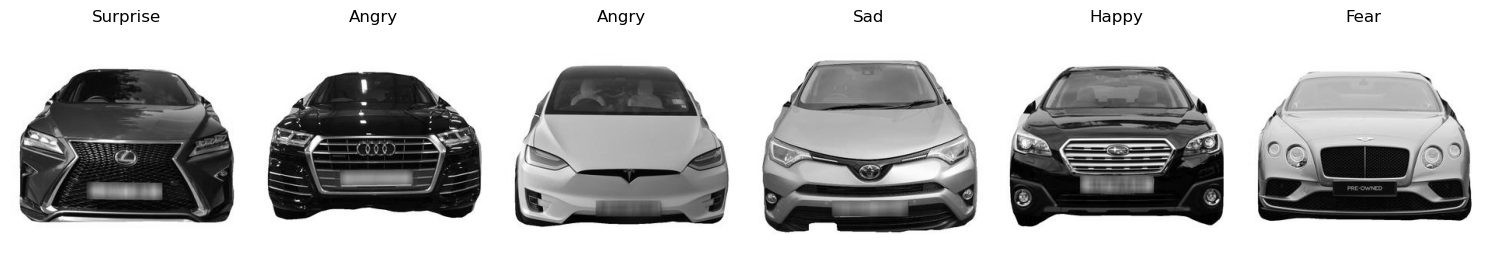

In [10]:
visualize_images(image_paths)

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image

root_dir = 'data/images/confirmed_fronts/'

# Get total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk(root_dir)])

# Create a tqdm object
pbar = tqdm(total=total_files, desc="Processing files")

# Initialize an empty list to store results
results = []
avg_probs = np.array([])

# Counter for visualizing every 100 images
image_counter = 0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        image, label, probs = predict_expression(full_path)
        # Store results
        result = {
            'image_path': full_path,
            'label': label
        }
        # Add probability columns
        for i, prob in enumerate(probs):
            result[f'prob_{CLASS_INDEX[i].lower()}'] = prob
        
        results.append(result)
        pbar.update(1)

pbar.close()
# Create DataFrame from results
df = pd.DataFrame(results)

# Display the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
df.to_csv('expression_results.csv', index=False)

In [14]:
df = pd.read_csv('data/expression_results.csv')

/var/folders/kz/4x196bzn2t9g3grd42yc9gy00000gn/T/ipykernel_65631/3505276761.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images['year'] = images['image_path'].apply(lambda x: x.split('$$')[2])


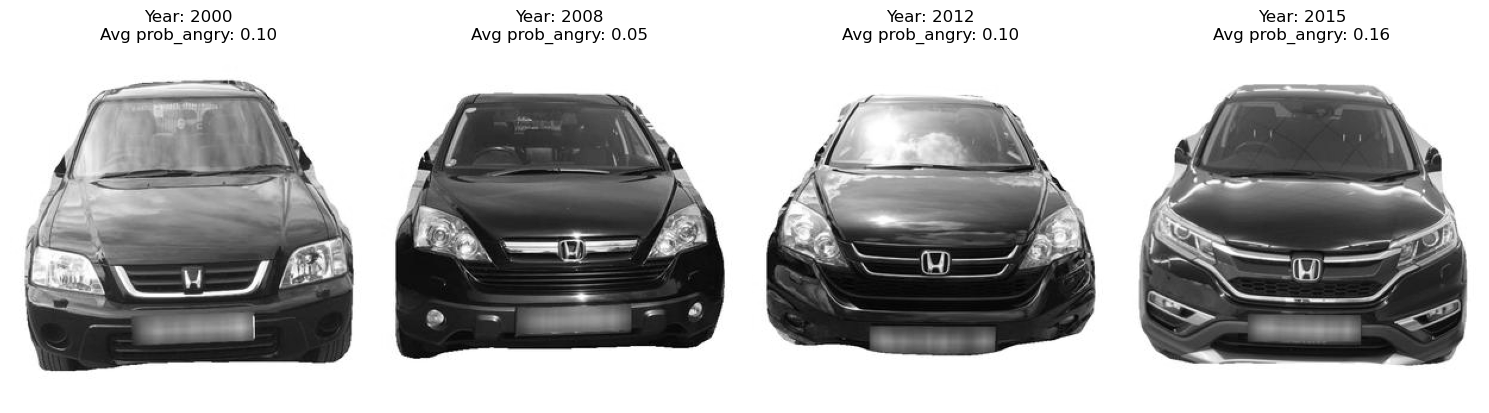

In [35]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Filter images containing 'C-RV'
images = df[df['image_path'].str.contains('CR-V')]

# Extract year from image path
images['year'] = images['image_path'].apply(lambda x: x.split('$$')[2])

# Calculate average prob_angry for each year
avg_prob_angry_by_year = images.groupby('year')['prob_angry'].mean()

# Determine the unique years and sort them
unique_years = sorted(images['year'].unique())

# Ensure at most four years by selecting suitable years
# For instance, equally spaced years if there are more than four
if len(unique_years) > 4:
    # Select however you see fit; here's a simple equally spaced selection
    step = max(1, len(unique_years) // 4)
    selected_years = unique_years[::step][:4]  # Ensure at most four elements
else:
    selected_years = unique_years

# Sample one image per selected year
sampled_images = images[images['year'].isin(selected_years)].groupby('year').sample(n=1)

# Get list of image_paths
image_paths = sampled_images['image_path'].tolist()
years = sampled_images['year'].tolist()

# Plot images with captions
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
if len(image_paths) == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one image

for ax, img_path, year in zip(axes, image_paths, years):
    # Open and display image in grayscale
    image = Image.open(img_path).convert('L') 
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Hide axis

    # Set caption with the average prob_angry
    avg_prob_angry = avg_prob_angry_by_year.loc[year]
    ax.set_title(f'Year: {year}\nAvg prob_angry: {avg_prob_angry:.2f}')

plt.tight_layout()
plt.show()

/var/folders/kz/4x196bzn2t9g3grd42yc9gy00000gn/T/ipykernel_65631/3048170510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images['year'] = images['image_path'].apply(lambda x: x.split('$$')[2])


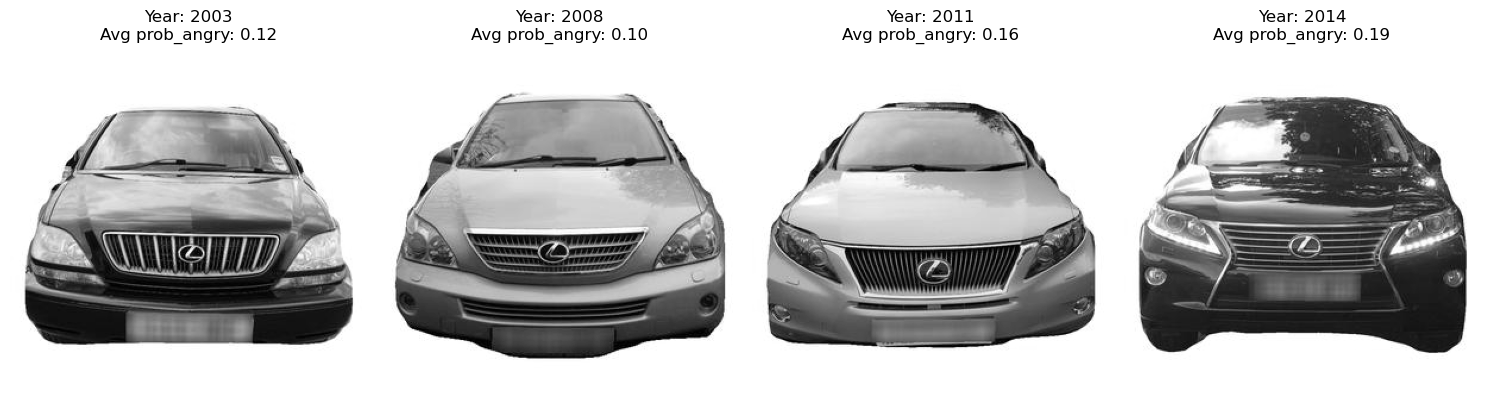

In [61]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Filter images containing 'C-RV'
images = df[df['image_path'].str.contains('RX') & df['image_path'].str.contains('Lexus')]

# Extract year from image path
images['year'] = images['image_path'].apply(lambda x: x.split('$$')[2])

avg_prob_angry_by_year = images.groupby('year')['prob_angry'].mean()

# Determine the unique years and sort them
unique_years = sorted(images['year'].unique())

# Ensure at most four years by selecting suitable years
# For instance, equally spaced years if there are more than four
if len(unique_years) > 4:
    # Select however you see fit; here's a simple equally spaced selection
    step = max(1, len(unique_years) // 4)
    selected_years = unique_years[::step][:4]  # Ensure at most four elements
else:
    selected_years = unique_years

# Sample one image per selected year
sampled_images = images[images['year'].isin(selected_years)].groupby('year').sample(n=1)

# Get list of image_paths
image_paths = sampled_images['image_path'].tolist()
years = sampled_images['year'].tolist()

# Plot images with captions
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
if len(image_paths) == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one image

for ax, img_path, year in zip(axes, image_paths, years):
    # Open and display image in grayscale
    image = Image.open(img_path).convert('L') 
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Hide axis

    avg_prob_angry = avg_prob_angry_by_year.loc[year]
    ax.set_title(f'Year: {year}\nAvg prob_angry: {avg_prob_angry:.2f}')

plt.tight_layout()
plt.show()